##Requirements

Calling tensorflow, matplotlib, pandas, numpy and other libraries for prediction and visualization aid.

In [ ]:
%tensorflow_version 2.x
%matplotlib inline
!pip show tensorflow

Name: tensorflow
Version: 2.4.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: astunparse, flatbuffers, protobuf, tensorflow-estimator, absl-py, google-pasta, termcolor, tensorboard, typing-extensions, gast, wrapt, six, wheel, grpcio, opt-einsum, keras-preprocessing, numpy, h5py
Required-by: fancyimpute


In [ ]:
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

##Function for making MAT data usable for prediction

The data that we used here is a part of NASA's Prognostics Center of Excellence Repository. It can be accessed at the following link: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#battery
The data files are in .mat format. We required a function that can convert these highly branched .mat data to simpler dataframe that can be used for learning the patterns from.

In [ ]:
def load_data(battery):
  mat = loadmat(battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]

Now we used this simpler dataframe in order to prepare training and testing sets for validation of the model in further steps.
Here we shall split the loaded data in main data and capacity data. In this specific case, the battery capacity data is used to predict the capacity in the following cycles using the first data of the first 50 cycles in such a way that we can know when the battery threshold is reached and estimate the missing cycles to reach the end of the battery life.

In [ ]:
dataset_val, capacity_val = load_data('B0005')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
rows=['cycle','capacity']
dataset=dis_ele[rows]
data_train=dataset[(dataset['cycle']<50)]
data_set_train=data_train.iloc[:,1:2].values
data_test=dataset[(dataset['cycle']>=50)]
data_set_test=data_test.iloc[:,1:2].values

sc=MinMaxScaler(feature_range=(0,1))
data_set_train=sc.fit_transform(data_set_train)
data_set_test=sc.transform(data_set_test)

X_train=[]
y_train=[]
#take the last 10t to predict 10t+1
for i in range(10,49):
    X_train.append(data_set_train[i-10:i,0])
    y_train.append(data_set_train[i,0])
X_train,y_train=np.array(X_train),np.array(y_train)
 
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]


##Neural Network building

Calling the necessary tensorflow models, layers and optimizers.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

Here we used LSTM( long short term memory) artificial recurrent neural network architecture. It's different from the standard neural networks is that, it has feedback capabilities unlike their feedforward connections.

In [ ]:
regress = Sequential()
regress.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1],1)))
regress.add(Dropout(0.3))
regress.add(LSTM(units=200, return_sequences=True))
regress.add(Dropout(0.3))
regress.add(LSTM(units=200, return_sequences=True))
regress.add(Dropout(0.3))
regress.add(LSTM(units=200))
regress.add(Dropout(0.3))
regress.add(Dense(units=1))
regress.compile(optimizer='adam',loss='mean_squared_error')
regress.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 200)           161600    
_________________________________________________________________
dropout (Dropout)            (None, 10, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 200)           320800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 200)           320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               3

##Train

In [ ]:
regress.fit(X_train,y_train,epochs=220,batch_size=25)

Epoch 1/220
2/2 [==============================] - 6s 89ms/step - loss: 0.3375
Epoch 2/220
2/2 [==============================] - 0s 89ms/step - loss: 0.1295
Epoch 3/220
2/2 [==============================] - 0s 87ms/step - loss: 0.1465
Epoch 4/220
2/2 [==============================] - 0s 87ms/step - loss: 0.0560
Epoch 5/220
2/2 [==============================] - 0s 86ms/step - loss: 0.1045
Epoch 6/220
2/2 [==============================] - 0s 81ms/step - loss: 0.0987
Epoch 7/220
2/2 [==============================] - 0s 83ms/step - loss: 0.0674
Epoch 8/220
2/2 [==============================] - 0s 85ms/step - loss: 0.0487
Epoch 9/220
2/2 [==============================] - 0s 85ms/step - loss: 0.0577
Epoch 10/220
2/2 [==============================] - 0s 86ms/step - loss: 0.0470
Epoch 11/220
2/2 [==============================] - 0s 85ms/step - loss: 0.0451
Epoch 12/220
2/2 [==============================] - 0s 83ms/step - loss: 0.0458
Epoch 13/220
2/2 [==============================]

##Test prep

Preparing the test data.

In [ ]:
print(len(data_test))
data_total=pd.concat((data_train['capacity'], data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)

119


##Testing

In [ ]:
X_test=[]
for i in range(10,129):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
pred=regress.predict(X_test)
print(pred.shape)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)
metrics.r2_score(tests,pred)

(119, 1)
Test RMSE: 0.064


0.7757345080685858

##Visual rep of results

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 50 -RULe=-8, window-size=10')

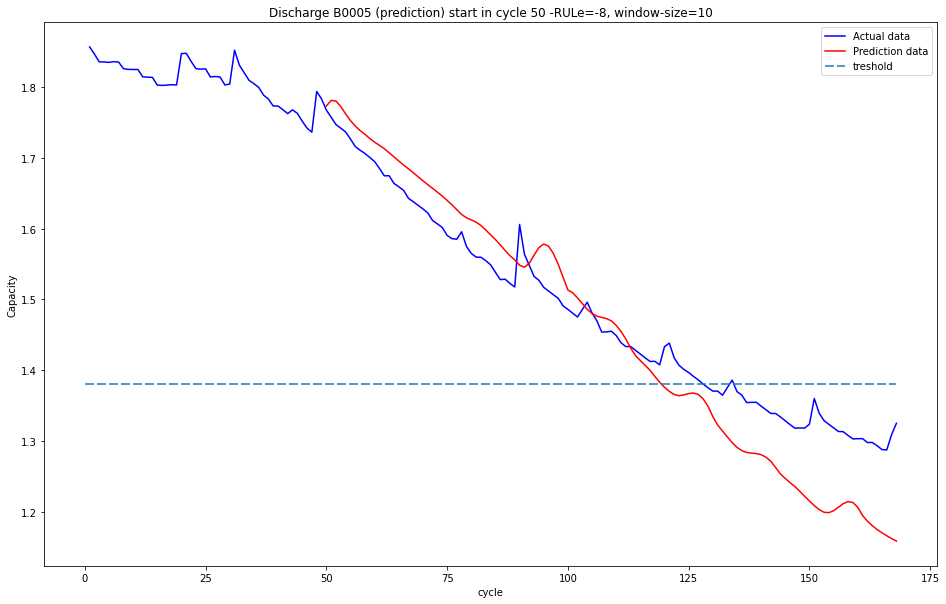

In [ ]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 50 -RULe=-8, window-size=10')

In [ ]:
pred=0
Afil=0
Pfil=0
a=data_test['capacity'].values
b=data_test['pre'].values
j=0
k=0
for i in range(len(a)):
    actual=a[i]
    
    if actual<=1.38:
        j=i
        Afil=j
        break
for i in range(len(a)):
    pred=b[i]
    if pred< 1.38:
        k=i
        Pfil=k
        break
print("The Actual fail at cycle number: "+ str(Afil+ln))
print("The prediction fail at cycle number: "+ str(Pfil+ln))
RULerror=Pfil-Afil
print("The error of RUL= "+ str(RULerror)+ " Cycle(s)")

The Actual fail at cycle number: 128
The prediction fail at cycle number: 119
The error of RUL= -9 Cycle(s)
